In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
rc('xtick', labelsize=14)    # fontsize of the tick labels
rc('ytick', labelsize=14)    # fontsize of the tick labels
import seaborn as sns

from sklearn.decomposition import PCA
#from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from glob import glob
from os.path import basename, splitext

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.stats import fisher_exact
from scipy.stats.contingency import expected_freq
from statsmodels.stats.multitest import fdrcorrection

from utils.structure import *

import mygene
import gseapy as gp
from gseapy.plot import barplot, dotplot

import sys
import json

# Clustering

In [2]:
# name = 'GSE38509$OSKM'
# df = pd.read_csv('tmp/%s_clusterdata.csv' % name, index_col=0)
# TIMES = {'GSE38509$OSKM':[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 8, 8, 10, 12],
#          'GSE38509$OSK':[3, 5, 8, 12],
#          'GSE114581$OSKM+dox_mef':[ 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 6.0, 12.0, 18.0],
#          'GSE127927$7F':[0, 0, 1, 1, 3, 3, 5, 5, 7, 7]}
# time = TIMES[name]

#avg dymnamics
name = "Mouse average dynamics"
df = pd.read_csv('dynamics_components/mouse_avg_dynamics_19ds.csv', index_col=0)

#combine columns with common time points
#df = df.T.groupby(time).mean().T
M = 1 - np.corrcoef(df)
time = list(map(float, df.columns.tolist()))
df.columns = time

#df = df.drop([14, 16, 20], 1)
time = list(map(int, df.columns.tolist()))

In [3]:
# ultradf = load_structure('./data/ultradf_v4.json')
# df_full = ultradf[name]['data']
# df_full = df_full.T.groupby(time).mean().T

In [4]:
# Instantiate the clustering model and visualizer
# model = AgglomerativeClustering(
#                             affinity='precomputed', 
#                             linkage='complete', 
#                             )
# visualizer = KElbowVisualizer(model, k=(2,10), timings=False)

# visualizer.fit(M)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [5]:
clst = AgglomerativeClustering(#n_clusters=visualizer.elbow_value_,
                            n_clusters=4,
                            affinity='precomputed', 
                            linkage='complete', 
                            #distance_threshold=.75
                            )
y_pred = clst.fit_predict(M)
y_pred = y_pred + 1 #increment cluster number

cluster_labels = sorted(np.unique(y_pred))
#set color palette for all plots
COLORS = list(sns.color_palette("bright"))[:len(cluster_labels)]
COLOR_DICT = dict(zip(cluster_labels, COLORS))

## Alternative clustering

In [6]:
## plot clusters obtained by threshold

# clusters = pd.DataFrame(np.unique(y_pred, return_counts=True), index=['index', 'count']).T
# clusters = clusters.sort_values('count', ascending=False)
# clusters.head(10)

# plt.figure(figsize=(10,8))
# for i in np.sort(clusters.head(10).index):
#     representers = df[y_pred==i]
#     se = representers.sem(0)
#     m = representers.mean(0)
#     t = representers.columns
#     # plt.plot(t, m, marker='o')
#     plt.errorbar(t, m, 1.96*se, label="Cluster %d: %d examples" % (i, len(representers)), lw=1.5)

# plt.title(name + " mean representation", fontsize=16)
# plt.xticks(np.arange(t.min(), t.max() + 1))
# plt.xlabel('Time, days', fontsize=14)
# plt.ylabel('Mean Z-score of expression', fontsize=14)
# plt.legend()
# plt.grid(alpha=0.4)
# plt.show()

In [7]:
##modify agglomerative clustering to construct Silhouette plot

# class AC(AgglomerativeClustering):
#     def __init__(self, model, *args, **kwargs):
#         self.model = model
#         self.n_clusters = self.model.n_clusters
        
#     def predict(self, X):
#         return self.model.fit_predict(X)

#     def fit(self, X):
#         return self.model.fit(X)

# model = AgglomerativeClustering(5, 
#                             affinity='precomputed', 
#                             linkage='complete')
# model = AC(model)                            

# visualizer = SilhouetteVisualizer(model)
# visualizer.fit(M)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure        

In [8]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# linked = linkage(df, 'single', 'cosine')

# plt.figure(figsize=(10, 7))
# dendrogram(linked,
#             p=20,
#             orientation='top',
#             distance_sort='descending',
#             show_leaf_counts=True, 
#             truncate_mode = 'lastp',
#             no_labels=True
#             )
# plt.show()

## vizualization

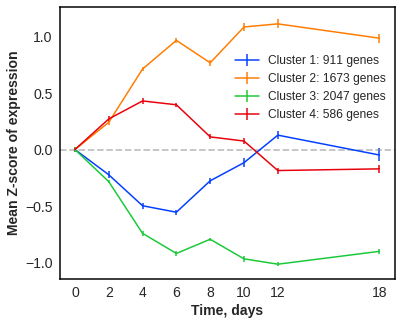

In [10]:
## cluster centroids plot
plt.figure(figsize=(6,5))
plt.rcParams["axes.edgecolor"] = "0."
plt.rcParams["axes.linewidth"]  = 1.5
for i, color in COLOR_DICT.items():
    representers = df[y_pred==i]
    se = representers.sem(0)
    m = representers.mean(0)
    m = m - m.iloc[0]
    t = representers.columns
    # plt.plot(t, m, marker='o')
    plt.errorbar(t, m, 1.96*se, label="Cluster %d: %d genes" % (i, len(representers)), lw=1.5, color=color)

#plt.title(name + " mean representation", fontsize=14)

plt.xticks(t, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time, days', fontsize=14, fontweight='bold')
plt.ylabel('Mean Z-score of expression', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, bbox_to_anchor=(0.49, 0.54))
plt.grid(alpha=0.)
plt.axhline(0., alpha=0.5, ls='--', color='grey')

plt.savefig('figs/panel4/%s_cluster_dynamics.svg' % name, format='svg', dpi=300, bbox_inches='tight')
#plt.show()

In [11]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

linkage = hc.linkage(sp.distance.squareform(M, checks=False), method='complete')

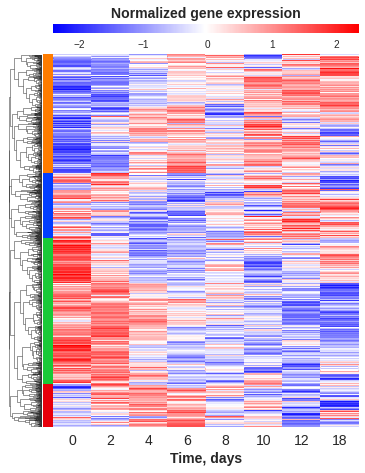

In [44]:
# normalize data to correct plotting
#y_sorted = y_pred[y_pred.argsort()]
df_norm = ((df.T - np.array(df.mean(1))) / df.std(1)).T 
#df_norm = df_norm.iloc[y_pred.argsort(),:]
row_colors = [COLOR_DICT[y] for y in y_pred]
fig = sns.clustermap(df_norm, #row_linkage=linkage, 
                figsize=(6, 6.4),
                metric='correlation', method='complete',
                cbar_kws = {"use_gridspec":False, "orientation":"horizontal"},
                cmap='bwr', col_cluster=False, row_colors=row_colors,
                dendrogram_ratio=0.1,
                tree_kws={'linewidths':0.5,
                    #'colors':row_colors
                    })

fig.ax_cbar.set_position([fig.ax_heatmap.get_position().xmin, 0.92, fig.ax_heatmap.get_position().width, 0.02])                    
fig.ax_heatmap.set_yticklabels([])
fig.ax_cbar.set_title('Normalized gene expression', fontsize=14, fontweight='bold')
#fig.ax_heatmap.set_xticklabels(fontsize=14)
fig.ax_heatmap.set_xlabel('Time, days', fontsize=14, fontweight='bold')
fig.ax_heatmap.set_ylabel('', fontsize=14)
fig.ax_heatmap.set_xticklabels(time, fontsize=14)
#fig.ax_heatmap.set_title('title');

fig.savefig('figs/panel4/%s_cluster_heatmap.svg' % name, format='svg', dpi=300, bbox_inches='tight')

In [ ]:
##vizualisation by dimensionality reduction
# um = UMAP(metric='correlation')
# pca = PCA(2)

# Xu = um.fit_transform(df_norm)
# Xp = pca.fit_transform(df_norm)

# plt.figure(figsize=(15,6))
# plt.subplot(121)
# sns.scatterplot(x=Xu[:,0], y=Xu[:, 1], hue=y_pred, s=4)
# plt.grid(alpha=0.5)
# plt.title('UMAP (pearson R metic)')

# plt.subplot(122)
# sns.scatterplot(x=Xp[:,0], y=Xp[:, 1], hue=y_pred, s=4)
# plt.grid(alpha=0.5)
# plt.title('PCA')
# plt.show()

In [ ]:
# ##random representer
# cluster = 3
# c = df[y_pred==cluster]

# fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharex=True)
# fig.suptitle('Random cluster %d representers' % cluster, fontsize=20)
# for ax in axes.flatten():
#     s = c.sample(1)
#     g = s.index[0]
#     ax.plot(c.columns, s.values[0])
#     ax.set_title(g)
# plt.show()    

## Clustering a cluster

In [ ]:
#cluster a cluster
# df_ = df[y_pred==4]
# M_ =  1 - np.corrcoef(df_)

# # Instantiate the clustering model and visualizer
# model = AgglomerativeClustering(
#                             affinity='precomputed', 
#                             linkage='complete')
# visualizer = KElbowVisualizer(model, k=(2,15))

# visualizer.fit(M_)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [ ]:
# clst_ = AgglomerativeClustering(6,
#                             affinity='precomputed', 
#                             linkage='average')
# y_pred_ = clst_.fit_predict(M_)

# plt.figure(figsize=(10,8))
# for i in np.sort(np.unique(y_pred_)):
#     representers = df_[y_pred_==i]
#     se = representers.sem(0)
#     m = representers.mean(0)
#     t = representers.columns
#     # plt.plot(t, m, marker='o')
#     plt.errorbar(t, m, 1.96*se, label="Cluster %d: %d examples" % (i, len(representers)), lw=1.5)

# plt.title(name + " mean representation", fontsize=16)
# plt.xticks(np.arange(t.min(), t.max() + 1))
# plt.xlabel('Time, days', fontsize=14)
# plt.ylabel('Mean Z-score of expression', fontsize=14)
# plt.legend()
# plt.grid(alpha=0.4)
# plt.show()

# Longevity signatures in clusters

In [15]:
lis = [s for s in sorted(glob('signatures/*')) if ("Aging:" in s) or ("Interventions:" in s)]

#l = lis[-3]
#cluster = 5
k = -1
pvals = []
res_dict = {}
print('DATASET %s' % name)
for l in lis:
    signature_name = splitext(basename(l))[0]
    
    age = pd.read_csv(l, index_col=0)
    age = age.loc[df.index.intersection(age.index),:] #intersection with only genes from dataframe
    
    for cluster in cluster_labels:
        df_sub = df[y_pred==cluster]
        n_cluster = len(df_sub)
        df_sub = df_sub.loc[df_sub.index.intersection(age.index), :]
        for age_direction in ['upregulated', 'downregulated']:
            if age_direction == 'upregulated':
                age_sub = age[(age.FDR < 0.05) & (age.logFC > 0)].sort_values('logFC', ascending=False)
            elif age_direction == 'downregulated':
                age_sub = age[(age.FDR < 0.05) & (age.logFC < 0)].sort_values('logFC', ascending=False)

            index_int = age_sub.index.intersection(df_sub.index)
            df_int = df.loc[index_int, :]
            
            if len(df_int) > 0:
                cmat = np.array([[len(df_int), len(df_sub) - len(df_int)], 
                                 [len(age_sub) - len(df_int), 
                                  len(age) - len(df_sub) - len(age_sub) + len(df_int) ]])
                f, p = fisher_exact(cmat)
                pvals.append(p)
                k += 1

                #if p < 0.05:
                OE = cmat - expected_freq(cmat)
                presentness = 'Overrepresented' if OE[0,0] > OE[0, 1] else 'Underrepresented'
                #write results
                res_dict[k] = (
                        signature_name, 
                        age_direction,
                        cluster, 
                        n_cluster,
                        len(index_int), 
                        p, 
                        presentness, 
                        cmat)


res = pd.DataFrame(res_dict).T
res.columns = ['Signature', 'Direction', 'Cluster', 'N_cluster', 'N_genes', 'pval', 'Representness', 'CMAT']
passed, fdr = fdrcorrection(res.pval)
res['pass'] = passed
res['pval_FDR'] = fdr
res['N genes passed'] = res['N_genes'] * res['pass']
res['Percent genes passed'] = res['N genes passed'] / res['N_cluster'] * 100
res['Percent genes passed'] = np.where(res['Percent genes passed']!=0., res['Percent genes passed'], np.nan)
res['Cluster_coord'] = np.where(res['Direction']=='upregulated', res['Cluster'] - 0.07, res['Cluster'] + 0.07) #jitter
res = res.sort_values(['Signature', 'Cluster_coord'])
#filter nonwhere significant
grp = res.groupby('Signature')['pass'].sum()
res = res[~res.Signature.isin(grp[grp == 0].index)]
        

DATASET Mouse average dynamics


In [16]:
res

,Signature,Direction,Cluster,N_cluster,N_genes,pval,Representness,CMAT,pass,pval_FDR,N genes passed,Percent genes passed,Cluster_coord
4,Aging:Brain,upregulated,1,911,69,1.89345e-06,Overrepresented,"[[69, 729], [162, 3605]]",True,8.58256e-05,69,7.57409,0.93
5,Aging:Brain,downregulated,1,911,21,0.116535,Underrepresented,"[[21, 777], [143, 3624]]",False,0.240353,0,NaN,1.07
6,Aging:Brain,upregulated,2,1673,60,0.050351,Underrepresented,"[[60, 1397], [171, 2937]]",False,0.138465,0,NaN,1.93
7,Aging:Brain,downregulated,2,1673,39,0.0262041,Underrepresented,"[[39, 1418], [125, 2983]]",False,0.0894553,0,NaN,2.07
8,Aging:Brain,upregulated,3,2047,92,0.890267,Overrepresented,"[[92, 1706], [139, 2628]]",False,0.986911,0,NaN,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Interventions:Median_lifespan,downregulated,2,1673,201,2.21799e-08,Underrepresented,"[[201, 1387], [650, 2786]]",True,2.19581e-06,201,12.0143,2.07
87,Interventions:Median_lifespan,upregulated,3,2047,356,0.00736822,Underrepresented,"[[356, 1629], [639, 2400]]",True,0.033157,356,17.3913,2.93
88,Interventions:Median_lifespan,downregulated,3,2047,398,2.60077e-06,Overrepresented,"[[398, 1587], [453, 2586]]",True,8.58256e-05,398,19.4431,3.07
89,Interventions:Median_lifespan,upregulated,4,586,113,1,Underrepresented,"[[113, 459], [882, 3570]]",False,1,0,NaN,3.93


In [17]:
# pal = list(sns.color_palette("tab10"))

# N = len(res.Cluster.unique())
# fig = plt.figure(figsize=(10, 7))
# ax1 = fig.add_subplot(3, N, (1, N))
# low_axes = [fig.add_subplot(3, N, N + i + 1, aspect=1.) for i in range(N)]
# ax2 = fig.add_subplot(3, N, (2*N+1, 3*N))

# g = sns.scatterplot(data=res, x='Cluster_coord', y='Signature', 
#         hue='Representness', size='Percent genes passed', style='Direction', markers=["^", "v"],
#                     palette="seismic", legend=True, sizes=(30, 250), ax=ax1, 
#                     hue_order=['Underrepresented', 'Overrepresented'], style_order=['upregulated', 'downregulated'])
# legend = g.legend(loc=6, bbox_to_anchor=(1, 0.35), ncol=1,  title_fontsize='x-large', 
#                 columnspacing=4, handletextpad=1, labelspacing=1, fancybox=True)

# for leg_block in legend.get_texts():
#         leg_title = leg_block.get_text()
#         if leg_title in ['Representness', 'Percent genes passed', 'Direction']:
#                 leg_title = leg_title.replace(' ', '\ ')
#                 leg_title = leg_title.replace('Percent', '\%')
#                 leg_block.set_text(r'$\bf{%s}$' % leg_title)
#                 #leg_block.set_x(-10.)

# #g.set_title('Dataset ' + name, fontsize=14)
# g.set_xlim([res.Cluster.min() - 0.5, res.Cluster.max() + 0.5])
# g.set_xlabel('Cluster', fontsize=14, fontweight='bold')
# g.set_ylabel('', fontsize=14)
# from matplotlib.ticker import MaxNLocator
# g.xaxis.set_major_locator(MaxNLocator(integer=True))
# g.tick_params(axis='both', which='major', labelsize=14)
# g.grid(alpha=0.3)

# for (cl, color), ax in zip(COLOR_DICT.items(), low_axes):
#         representers = df[y_pred==cl]
#         sd = representers.std(0)
#         se = representers.sem(0)
#         m = representers.mean(0)
#         m = m - m.iloc[0]
#         t = representers.columns
#         #ax.errorbar(t, m/sd, 1.96*se/sd, lw=1.5, color=color)
#         ax.errorbar(t, m, 1.96*se, lw=1.5, color=color)
#         ax.axhline(0, color='grey', lw=0.5)
#         ax.set_xlim([t.min()-0.2, t.max()+0.2])
#         ax.set_ylim([-1.5, 1.5])
#         ax.set_aspect((t.max() - t.min()) / (1.5 * 2))
#         ax.set_title('N=%d' % len(representers))
#         ax.set_xticks([])
#         ax.set_yticks([])
# plt.subplots_adjust(hspace=0.1)

#plt.savefig('figs/panel4/%s_signature_enrich.svg' % name, format='svg', dpi=300, bbox_inches='tight')

In [18]:
# for i in np.argwhere(fdrcorrection(pvals)[0]).ravel():
#     print(res_dict[i][:-1])     
#     cmat = res_dict[i][-1]

    # plt.figure(figsize=(4,3.6))
    # sns.heatmap((cmat - expected_freq(cmat)), annot=True, cmap='PiYG', #fmt='.0f',
    #         xticklabels=['Significant', 'Non-Significant'], 
    #         yticklabels=['In cluster', 'Not in cluster'])
    # plt.yticks(va="center")
    # plt.title('Fisher\'s test pval = %s' % np.format_float_scientific(p, exp_digits=3, precision=3))
    # plt.show()    

In [19]:
## plot centroid of Significant + InCluster genes

# t = df_int.columns
# m = df_int.mean(0)
# se = df_int.sem(0)

# plt.errorbar(t, m, 1.96 * se, lw=1.5)
# plt.title('Top %d genes of %s signature in cluster %d' % (len(index_int), signature_name, cluster))
# plt.xticks(np.arange(t.min(), t.max() + 1))
# plt.ylabel('Mean Z-score of expression', fontsize=14)
# plt.xlabel('Time, days', fontsize=14)
# plt.grid(alpha=0.7)
# #plt.legend()
# plt.show()

# pyGSEA

In [20]:
import mygene
import gseapy as gp
from gseapy.plot import barplot, dotplot

def key2key(df, key, target, species='mouse'):
    df = df.copy()
    raw = df.index.tolist()
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2target = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if target in q:
            ref2target[r].append(q[target])
        else:
            ref2target[r] = None

    print('Max number of ENTREZ across keys:', 
          max([len(ref2target[r]) for r in ref2target.keys() if ref2target[r] is not None]))

    ref2target = {k:v[0] for k,v in ref2target.items() if (v is not None) and (len(v)==1)}
    df.index = df.index.map(ref2target, na_action=None)
    df = df[~df.index.isna()]
    return df, ref2target

def add_subplot_axes(ax, rect, cl):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    representers = df[y_pred==cl]
    sd = representers.std(0)
    se = representers.sem(0)
    m = representers.mean(0)
    m = m - m.iloc[0]
    t = representers.columns
    subax.errorbar(t, m/sd, 1.96*se/sd, lw=1.5, color=pal[cl])
    subax.axhline(0, color='grey', lw=0.5)
    subax.set_xlim([t.min()-0.2, t.max()+0.2])
    subax.set_ylim([-2., 2.])
    subax.set_aspect((t.max() - t.min()) / (2. * 2))
    subax.set_xticks([])
    subax.set_yticks([])
    return subax

In [21]:
df_sym, dictionary = key2key(df, key='entrezgene', target='symbol')

#assert (np.array(df_sym) == np.array(df)).all()

Max number of ENTREZ across keys: 1


In [22]:
try:
    assert (np.array(df_sym) == np.array(df)).all()
    y_pred_sym = y_pred
except:
    assert (np.array(df.loc[list(dictionary.keys())]) == np.array(df_sym)).all()
    y_pred_sym = y_pred[[df.index.get_loc(i) for i in list(dictionary.keys())]]
    print('Before', len(y_pred), 'After', len(y_pred_sym))
    pass

In [ ]:
# mouse_lib = gp.get_library_name('Mouse')
# mouse_lib

In [23]:
# udf = load_structure('data/ultradf_v4.json')

# #get gene universe
# fdf = udf[name]['data']
# ftime = udf[name]['time']
# fdf = fdf.T.groupby(ftime).sum()
fdf = pd.read_csv('dynamics_components/mouse_universe.csv', index_col=0)
#fdf = pd.read_csv('reprogramming_mouse_full.csv', index_col=0)
print("universe length:", len(fdf))

fdf_sym, dictionary = key2key(fdf, key='entrezgene', target='symbol')
universe = fdf_sym.index.unique().tolist()
universe = list(map(str.upper, universe))

universe length: 7292
Max number of ENTREZ across keys: 1


In [24]:
terms_list =  [ 'MSigDB_Hallmark_2020:::Androgen Response',
                'MSigDB_Hallmark_2020:::Angiogenesis',
                'MSigDB_Hallmark_2020:::Apical Junction',
                'MSigDB_Hallmark_2020:::Apoptosis',
                'MSigDB_Hallmark_2020:::Bile Acid Metabolism',
                'MSigDB_Hallmark_2020:::Cholesterol Homeostasis',
                'MSigDB_Hallmark_2020:::DNA Repair',
                'MSigDB_Hallmark_2020:::E2F Targets',
                'MSigDB_Hallmark_2020:::Epithelial Mesenchymal Transition',
                #'HALLMARK_ESTROGEN_RESPONSE_EARLY',
                'MSigDB_Hallmark_2020:::Fatty Acid Metabolism',
                'MSigDB_Hallmark_2020:::G2-M Checkpoint',
                'MSigDB_Hallmark_2020:::heme Metabolism',
                'MSigDB_Hallmark_2020:::Hypoxia',
                'MSigDB_Hallmark_2020:::IL-6/JAK/STAT3 Signaling',
                'MSigDB_Hallmark_2020:::Inflammatory Response',
                'MSigDB_Hallmark_2020:::Interferon Alpha Response',
                'MSigDB_Hallmark_2020:::KRAS Signaling Up',
                #'HALLMARK_MITOTIC_SPINDLE',
                'MSigDB_Hallmark_2020:::Myc Targets V1',
                'MSigDB_Hallmark_2020:::Myogenesis',
                'MSigDB_Hallmark_2020:::Oxidative Phosphorylation',
                'MSigDB_Hallmark_2020:::p53 Pathway',
                'MSigDB_Hallmark_2020:::PI3K/AKT/mTOR  Signaling',
                'MSigDB_Hallmark_2020:::Protein Secretion',
                'MSigDB_Hallmark_2020:::Spermatogenesis',
                'MSigDB_Hallmark_2020:::TGF-beta Signaling',
                'MSigDB_Hallmark_2020:::TNF-alpha Signaling via NF-kB',
                'MSigDB_Hallmark_2020:::Unfolded Protein Response',
                'MSigDB_Hallmark_2020:::UV Response Dn',
                'MSigDB_Hallmark_2020:::Xenobiotic Metabolism',
                'KEGG_2019_Mouse:::Complement and coagulation cascades',
                'KEGG_2019_Mouse:::Base excision repair',
                'GO_Biological_Process_2021:::regulation of ATP metabolic process (GO:1903578)',
                'KEGG_2019_Mouse:::Citrate cycle (TCA cycle)',
                'GO_Biological_Process_2021:::mitochondrial translation (GO:0032543)',
                'KEGG_2019_Mouse:::Ribosome']

In [25]:
from gseapy.parser import gsea_gmt_parser   
set_names = ['MSigDB_Hallmark_2020', 
            'KEGG_2019_Mouse', 
            'Reactome_2016', 
            'GO_Biological_Process_2021'
            ]
#set_names_dict = {'MSigDB_Hallmark_2020'}
gene_sets = {}
for g in set_names:
    gs = gsea_gmt_parser(g)
    for k,v in gs.items():
        idx = g+':::'+k
        if idx in terms_list:
            gene_sets[idx] = v

/home/shappiron/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/shappiron/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/shappiron/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning

In [26]:
# gene_sets=['GO_Biological_Process_2021', 'KEGG_2019_Mouse', 'Reactome_2016', 
#             'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down']   

results_dict = {}
for cluster in sorted(np.unique(y_pred_sym)):

    cluster_symbols = df_sym[y_pred_sym==cluster].index.to_list()
    cluster_symbols = list(map(str.upper, cluster_symbols))
    enr = gp.enrichr(gene_list=cluster_symbols,
                    gene_sets=gene_sets,
                    organism='Mouse', 
                    description='test_run',
                    outdir='tmp/enrichment/%s' % name,
                    cutoff=0.05, # test dataset, use lower value from range(0,1)
                    background=universe,
                    no_plot=True
                    )
    eres = enr.results    
    results_dict[cluster] = eres

    # ax = dotplot(eres, title='Dataset %s: Cluster %d enrichment' % (name, cluster), cmap='viridis_r')
    # rect = [0.7, 0.05, 0.25, 0.25]
    # add_subplot_axes(ax, rect, cluster)
    # plt.show()

In [27]:
enrich = pd.DataFrame()
for cl,v in results_dict.items():    
    v['Cluster'] = [cl] * len(v)
    enrich = enrich.append(v)

enrich = enrich.reset_index()
enrich['passed'] = enrich['Adjusted P-value'] < 0.05
enrich['Odds Ratio'] = enrich['Odds Ratio'] * enrich['passed']
enrich['Odds Ratio'] = np.where(enrich['Odds Ratio'] == 0, np.nan, enrich['Odds Ratio'])
enrich['-log10(adj.P-value)'] = -np.log10(enrich['Adjusted P-value'])
enrich = enrich.sort_values(['Term', 'Cluster'])

gr = enrich.groupby('Term')['passed'].sum()
enrich = enrich.drop(enrich[enrich.Term.isin(gr[gr == 0].index.tolist())].index)
enrich[['Gene_set', 'Term']] = enrich['Term'].str.split(':::', expand=True)

#decorations
for i, row in enrich.iterrows():
    pos = enrich.loc[i, 'Term'].find('(GO')
    if row['Gene_set'] == 'KEGG_2019_Mouse':
        enrich.loc[i, 'Term'] += ' (KEGG)'
    elif pos != -1:
        enrich.loc[i, 'Term'] = enrich.loc[i, 'Term'][:pos]
    elif row['Gene_set'] == 'Reactome_2016':
         enrich.loc[i, 'Term'] += ' (Reactome)'

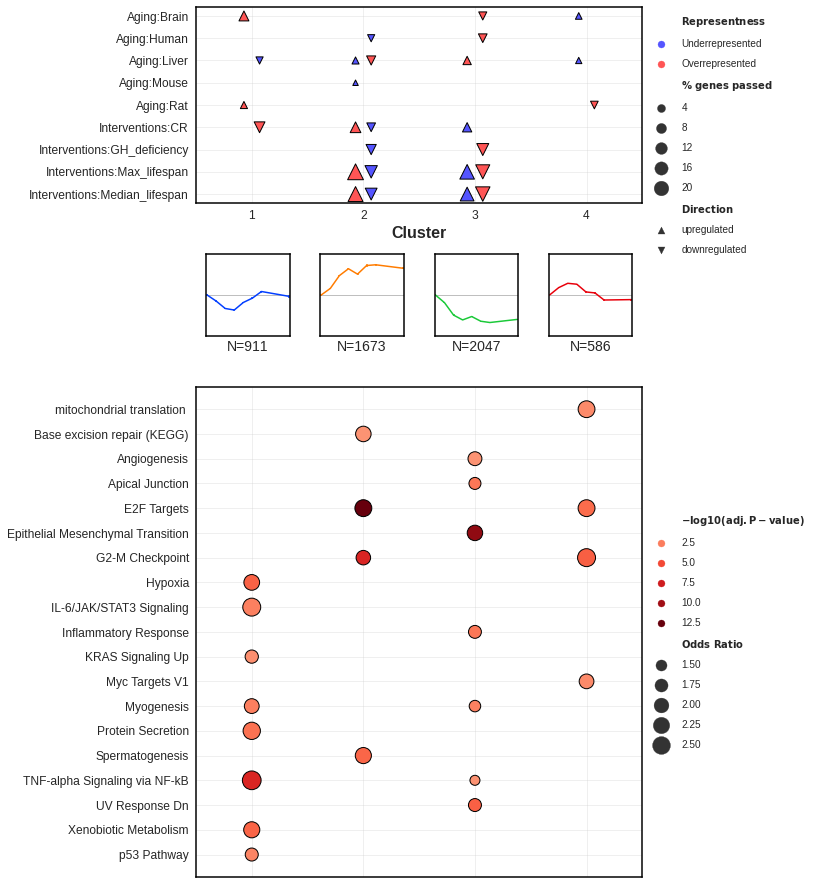

In [34]:
pal = list(sns.color_palette("bright"))

N = len(res.Cluster.unique())
fig = plt.figure(figsize=(8, 16))
plt.rcParams["axes.edgecolor"] = "0."
plt.rcParams["axes.linewidth"]  = 1.5

from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=N, nrows=3,
                         width_ratios=[1 for _ in range(N)], wspace=0.1,
                         hspace=0.2, height_ratios=[1.2, 0.5, 3])

ax1 = fig.add_subplot(spec[0:N])
low_axes = [fig.add_subplot(spec[N + i], aspect=1.) for i in range(N)]
ax2 = fig.add_subplot(spec[2*N:3*N])

###Signature
g = sns.scatterplot(data=res, x='Cluster_coord', y='Signature', 
        hue='Representness', size='Percent genes passed', style='Direction', markers=["^", "v"],
        linewidth=1.0, edgecolor='black',
        palette="seismic", legend=True, sizes=(30, 250), ax=ax1, 
        hue_order=['Underrepresented', 'Overrepresented'], style_order=['upregulated', 'downregulated'])
legend = g.legend(loc=6, bbox_to_anchor=(1, 0.35), ncol=1,  title_fontsize='x-large', 
                columnspacing=4, handletextpad=1, labelspacing=1, fancybox=True)

for leg_block in legend.get_texts():
        leg_title = leg_block.get_text()
        if leg_title in ['Representness', 'Percent genes passed', 'Direction']:
                leg_title = leg_title.replace(' ', '\ ')
                leg_title = leg_title.replace('Percent', '\%')
                leg_block.set_text(r'$\bf{%s}$' % leg_title)
                #leg_block.set_x(-10.)

#g.set_title('Dataset ' + name, fontsize=14)
g.set_xlim([res.Cluster.min() - 0.5, res.Cluster.max() + 0.5])
g.set_xlabel('Cluster', fontsize=16, fontweight='bold')
g.set_ylabel('', fontsize=14)
from matplotlib.ticker import MaxNLocator
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.tick_params(axis='both', which='major', labelsize=12)
g.grid(alpha=0.3)

###Average dynamics
for (cl, color), ax in zip(COLOR_DICT.items(), low_axes):
        representers = df[y_pred==cl]
        sd = representers.std(0)
        se = representers.sem(0)
        m = representers.mean(0)
        m = m - m.iloc[0]
        t = representers.columns
        #ax.errorbar(t, m/sd, 1.96*se/sd, lw=1.5, color=color)
        ax.errorbar(t, m, 1.96*se, lw=1.5, color=color)
        ax.axhline(0, color='grey', lw=0.5)
        ax.set_xlim([t.min()-0.2, t.max()+0.2])
        ax.set_ylim([-1.5, 1.5])
        ax.set_aspect((t.max() - t.min()) / (1.5 * 2))
        ax.set_xlabel('N=%d' % len(representers), fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])


###Term enrichment
g = sns.scatterplot(data=enrich, x='Cluster', y='Term',
        #order = sorted(res.Cluster.unique()),
        hue='-log10(adj.P-value)', size='Odds Ratio', 
        #style='Direction', markers=["^", "v"],
        palette="Reds", 
        linewidth=1.0, edgecolor='black',
        legend=True, sizes=(100, 350), ax=ax2, 
        hue_norm =(-5,12),
        style_order=['upregulated', 'downregulated'])
legend = g.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1,  title_fontsize='x-large', 
                columnspacing=4, handletextpad=1, labelspacing=1, fancybox=True)

for leg_block in legend.get_texts():
        leg_title = leg_block.get_text()
        if leg_title in ['-log10(adj.P-value)', 'Odds Ratio']:
                leg_title = leg_title.replace(' ', '\ ')
                leg_title = leg_title.replace('Percent', '\%')
                leg_block.set_text(r'$\bf{%s}$' % leg_title)
                #leg_block.set_x(-10.)

#g.set_title('Dataset ' + name + ' clusters vs MSigDB terms', fontsize=14)
g.set_xticks(range(1,5))
g.set_xticklabels([], fontsize=14)
g.set_xlim([enrich.Cluster.min() - 0.5, enrich.Cluster.max() + 0.5])
g.set_xlabel('', fontsize=16)
g.set_ylabel('', fontsize=14)
g.tick_params(axis='both', which='major', labelsize=12)
g.grid(alpha=0.3)

plt.subplots_adjust(hspace=0.1)
plt.savefig('figs/panel4/%s_cluster_full enrichment.svg' % name, format='svg', dpi=300, bbox_inches='tight')

# Combine SVG

In [35]:
import importlib
import svgutils
from svgutils.compose import *
from cairosvg import svg2png

In [36]:
svgA = SVG("figs/panel4/Mouse average dynamics_cluster_dynamics.svg")
svgB = SVG("figs/panel4/Mouse average dynamics_cluster_heatmap.svg")
svgC = SVG("figs/panel4/Mouse average dynamics_cluster_full enrichment.svg")
Figure(2.4 * svgA.width, 2.2 * svgA.height, 
        Panel(svgB,
              Text("A", 25, 20, size=20, weight='bold', font='Arial')
             ).scale(1.14),
        Panel(svgA,
              Text("B", 25, 20, size=20, weight='bold', font='Arial')
             ).move(0, 540),
        Panel(svgC,
              Text("C", 25, 20, size=20, weight='bold', font='Arial')
             ).move(420, 0).scale(0.95),
        ).save("./figs/panel4_compose.svg")

In [ ]:
#svg2png(file_obj=open("figs/panel4_compose.svg", "rb"), write_to='figs/panel4_top.png', dpi=600, scale=2)

# Plot signatures heatmap

In [ ]:
# sdf = pd.read_csv('signatures_slopes.csv', index_col=0)

In [ ]:
# # normalize data to correct plotting
# #y_sorted = y_pred[y_pred.argsort()]
# df_norm = sdf / sdf.std(0)
# df_norm = ((df_norm.T) / df_norm.T.std(0)).T 
# #df_norm = df_norm.iloc[y_pred.argsort(),:]
# #row_colors = [COLOR_DICT[y] for y in y_pred]
# fig = sns.clustermap(df_norm, #row_linkage=linkage, 
#                 metric='correlation', method='complete',
#                 cbar_kws = {"use_gridspec":False, "orientation":"vertical"},
#                 cmap='RdBu_r', col_cluster=True, #row_colors=row_colors,
#                 dendrogram_ratio=0.1,
#                 tree_kws={'linewidths':0.5,
#                     #'colors':row_colors
#                     })
# fig.ax_cbar.set_position([fig.ax_heatmap.get_position().xmax + 0.02, fig.ax_heatmap.get_position().ymin, 
#                             0.02, fig.ax_heatmap.get_position().height])                    
# fig.ax_heatmap.set_yticklabels([]);
# #fig.ax_heatmap.set_xticklabels(fontsize=14)
# #fig.ax_heatmap.set_xlabel('Signatures', fontsize=14);
# #fig.ax_heatmap.set_title('title');

# #fig.savefig('figs/panel3/signatures_cluster_heatmap.png', dpi=300, bbox_inches='tight')

# CMAP

In [ ]:
# reprog = pd.read_csv('reprogramming_full.csv', index_col=0)
# reprog = reprog.dropna()
# reprog['ES'] = -np.log10(reprog['FDR']) * np.sign(reprog['logFC'])

In [ ]:
# pval_thr = 0.05

# universe = reprog['symbol'].tolist()
# up_genes = reprog[(reprog['logFC'] > 0) & (reprog['FDR'] < pval_thr)]['symbol'].tolist()
# dw_genes = reprog[(reprog['logFC'] < 0) & (reprog['FDR'] < pval_thr)]['symbol'].tolist()

# universe = list(map(str.upper, universe))
# up_genes = list(map(str.upper, up_genes))
# dw_genes = list(map(str.upper, dw_genes))

# print(len(up_genes), len(dw_genes))

In [ ]:
# rnk = reprog[['symbol', 'ES']]
# rnk = rnk.reset_index().drop('index', 1)
# rnk.columns = [0, 1]
# rnk = rnk.sort_values(1, ascending=False)
# rnk[0] = rnk[0].apply(str.upper)

In [ ]:
# mouse_lib = gp.get_library_name('Mouse')
# mouse_lib

In [ ]:
# #GSEA
# results_dict = {}

# gene_sets = ['Old_CMAP_up', 'Old_CMAP_down', 
#              'LINCS_L1000_Chem_Pert_down', 'LINCS_L1000_Chem_Pert_up',]

# for gset in gene_sets:
#     enr = gp.prerank(rnk, gset, processes=12, permutation_num=1000,)
#     eres = enr.res2d   
#     results_dict[gset] = eres

# res = pd.DataFrame()
# for cl, v in results_dict.items():    
#     v['gset'] = [cl] * len(v)
#     res = res.append(v)

In [ ]:
# res

In [ ]:
# results_dict = {}

# gene_sets = ['Old_CMAP_up', 'Old_CMAP_down']
# for d, direction in zip(['up', 'down'], [up_genes, dw_genes]):
#     enr = gp.enrichr(gene_list=direction,
#                     gene_sets=gene_sets,
#                     organism='Mouse', 
#                     cutoff=0.05, # test dataset, use lower value from range(0,1)
#                     background=universe
#                     )
#     eres = enr.results    
#     results_dict[d] = eres

# res = pd.DataFrame()
# for cl,v in results_dict.items():    
#     v['Direction'] = [cl] * len(v)
#     res = res.append(v)

In [ ]:
# drugs = res[res['Adjusted P-value'] < 0.05]['Term'].tolist()